In [1]:
# imports
import os
import sys

# Adiciona o diretório raiz do projeto ao PYTHONPATH para importar o pacote local
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
from nasabinning.binning_engine import NASABinner
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# gerar dataset genérico
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    "idade": np.random.normal(40, 10, size=n),
    "renda": np.random.normal(3000, 800, size=n),
    "score": np.random.normal(600, 100, size=n),
    "AnoMesReferencia": np.random.choice([202301, 202302, 202303], size=n)
})

# target binário simulado
df["default_90d"] = (
    (df["score"] < 580) & (df["renda"] < 2800) & (np.random.rand(n) < 0.3)
).astype(int)

df.head()


,idade,renda,score,AnoMesReferencia,default_90d
0,44.967142,4119.484349,532.482173,202302,0
1,38.617357,3739.706946,585.548133,202302,0
2,46.476885,3047.704296,520.758008,202302,0
3,55.230299,2482.450578,569.203847,202301,0
4,37.658466,3558.578651,410.638533,202303,0


In [3]:
# usar NASABinner sem Optuna
binner = NASABinner(
    strategy="supervised",
    max_bins=5,
    min_event_rate_diff=0.03,
    monotonic=None,
    use_optuna=False,
    check_stability=True
)

X = df[["idade", "renda", "score"]]
y = df["default_90d"]
binner.fit(X, y, time_col="AnoMesReferencia")

print("IV:", round(binner.iv_, 4))
display(binner._bin_summary_.head())

IV: 0.461


,variable,bin,count,event,non_event,event_rate
0,idade,"(-inf, 24.70)",50,5,45,0.100000
1,idade,"[24.70, 42.55)",553,15,538,0.027125
2,idade,"[42.55, 46.45)",145,13,132,0.089655
3,idade,"[46.45, 54.43)",167,7,160,0.041916
4,idade,"[54.43, inf)",85,1,84,0.011765


(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Estabilidade temporal'}, xlabel='Safra', ylabel='Event Rate'>)

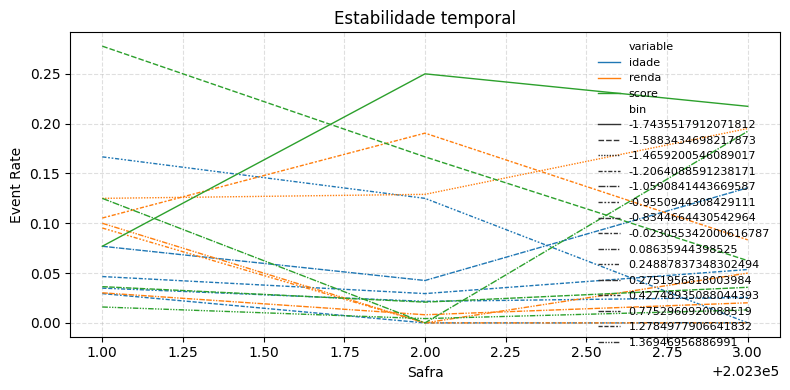

In [4]:
pivot = binner.stability_over_time(
    X=df[["idade", "renda", "score", "AnoMesReferencia"]],
    y=df["default_90d"],
    time_col="AnoMesReferencia"
)

binner.plot_event_rate_stability(pivot, title="Estabilidade temporal")

In [5]:
# testar NASABinner COM Optuna
binner_opt = NASABinner(
    strategy="supervised",
    use_optuna=True,
    check_stability=True,
    monotonic="descending",     # força tendência decrescente (ex: para score)
    strategy_kwargs={"n_trials": 15}
)
binner_opt.fit(X, y, time_col="AnoMesReferencia")

print("IV:", round(binner_opt.iv_, 4))
print("Melhores parâmetros:", getattr(binner_opt, "best_params_", None))
display(binner_opt._bin_summary_.head())


[I 2025-06-02 23:28:47,751] A new study created in memory with name: no-name-db824fa3-9a66-4e09-bf78-3aa159af85f0
[W 2025-06-02 23:28:47,752] Trial 0 failed with parameters: {'max_bins': 3, 'min_bin_size': 0.07714817844008756, 'min_event_rate_diff': 0.051956681350567045} because of the following error: TypeError("nasabinning.binning_engine.NASABinner() got multiple values for keyword argument 'min_event_rate_diff'").
Traceback (most recent call last):
  File "c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\NASABinning\nasabinning\optuna_optimizer.py", line 63, in <lambda>
    lambda tr: _objective(tr, X, y, base_kwargs, time_col),
  File "c:\Users\JM\Documents\0_CienciaDados\1_Frameworks\NASABinning\nasabinning\optuna_optimizer.py", line 31, in _objective
    binner = NASABinner(
TypeError: nasabinning.binning_engine.NASABi

TypeError: nasabinning.binning_engine.NASABinner() got multiple values for keyword argument 'min_event_rate_diff'

In [ ]:
# plotar estabilidade do modelo com Optuna
binner_opt.plot_event_rate_stability(title="Estabilidade temporal - com Optuna")